In [5]:
##Package

#Others
import os,shutil
import regex as re
import pandas as pd
import numpy as np
import tensorflow as tf
import time
from IPython.display import clear_output
import xmltodict as xml2dic
import xml.etree.ElementTree as ET

##Extraction Mask 
import remove_image as IOI


##Extracting Feartures
from extract_features import extract_image as XF

#modelling CNN
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D
from keras.layers import MaxPooling2D,Dropout
from keras.layers import Dense
from keras.layers import Flatten


#clustering the image by KMeans
from sklearn.cluster import KMeans

#Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.patches import Rectangle

##Preprocessing
import cv2
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#Clustering algorithm
from sklearn.cluster import KMeans

#Setting up dataset
from inputting_data import setting_up_data

##Reduction Features
from sklearn.decomposition import PCA


##evaluation of testing
import metrics_data as metrics

"""
os.chdir("D:/Workspace for Coding/Project Detection of Marine Object/NAFNet")
##Denoising and deblurring image
from basicsr.models import create_model
from basicsr.utils import img2tensor as _img2tensor, tensor2img, imwrite
from basicsr.utils.options import parse

"""

##Building the model
from detection_model import FRCNN_RESNET50_Model 
from detection_model import Detecto_File_CSV
from detection_model import Detecto_train



Built-in function 

In [7]:

def img2tensor(img, bgr2rgb=False, float32=True):
    img = img.astype(np.float32)/255.
    return _img2tensor(img, bgr2rgb=bgr2rgb, float32=float32)



def NAFNet(path_yml):
    opt_path = path_yml
    opt = parse(opt_path, is_train=False)
    opt['dist'] = False
    NAFNet_model = create_model(opt)
    return NAFNet_model

def cvt_deblur_denoise (model, img_tensor):
    model.feed_data(data={'lq': img_tensor.unsqueeze(dim=0)})

    if model.opt['val'].get('grids', False):
        model.grids()

    model.test()

    if model.opt['val'].get('grids', False):
        model.grids_inverse()

    visuals = model.get_current_visuals()
    sr_img = tensor2img([visuals['result']])
    return sr_img

def category_xml(directory_file):
    all_unit=[]
    dict_annotation=[]
    cat_array=[]
    size_box=[]
    path_annot=directory_file
    for path_file in os.listdir(path_annot):
        if path_file.endswith(('xml','XML')):
            file_xml=os.path.join(path_annot,path_file)
            with open(file_xml) as file:
                file_data=file.read()
                data_xml=xml2dic.parse(file_data)
                dict_annotation.append(data_xml)
    for idx in range(len(dict_annotation)):
        if isinstance(dict_annotation[idx]['annotation']['object'],list):
            for jdx in range(len(dict_annotation[idx]['annotation']['object'])):
                cat_array.append(dict_annotation[idx]['annotation']['object'][jdx]['name'])
                file_name=dict_annotation[idx]['annotation']['filename']
                category=dict_annotation[idx]['annotation']['object'][jdx]['name']
                data_keys=dict_annotation[idx]['annotation']['object'][jdx]['bndbox']
                for keys in data_keys.keys():
                    data_keys[keys]=int(data_keys[keys])
                all_unit.append((file_name,category))
                size_box.append(data_keys)
        else:
            cat_array.append(dict_annotation[idx]['annotation']['object']['name'])
            file_name=dict_annotation[idx]['annotation']['filename']
            category=dict_annotation[idx]['annotation']['object']['name']
            data_keys=dict_annotation[idx]['annotation']['object']['bndbox']
            for keys in data_keys:
                data_keys[keys]=int(data_keys[keys])
            size_box.append(data_keys)
            all_unit.append((file_name,category))

        print('Cat Pict:',dict_annotation[idx]['annotation']['filename'],' is extracted successfuly')

        clear_output(wait=True)
        time.sleep(0.01)
    tuple_arr=[(cat, cat_array.count(cat)) for cat in set(cat_array)]
    df_cat=pd.DataFrame(data=tuple_arr,columns=['category','size of category'])
    df_unit1=pd.DataFrame(data=all_unit,columns=['filename','category'])
    df_unit2=pd.DataFrame(data=size_box)
    df_unit=pd.concat([df_unit1, df_unit2], axis=1)
    return  df_cat,df_unit

def cropping_obj(df, directory):
    array_crop=[]
    df_new=df.copy()
    for idx,name_file in zip(df_new.iloc[:,0].index,df_new.iloc[:,0]):
        path_file=os.path.join(directory,name_file)
        image=cv2.imread(path_file)
        conv=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        x0=df_new.loc[idx,'xmin']
        x1=df_new.loc[idx,'xmax']
        y0=df_new.loc[idx,'ymin']
        y1=df_new.loc[idx,'ymax']
        array_crop.append(conv[y0:y1,x0:x1])
    return array_crop

def resizing_image(image,resize,xmin=0,xmax=0,ymin=0,ymax=0):
    x_image,y_image=image.shape[:2]
    targetsize=resize

    img_resize=cv2.resize(image,(targetsize,targetsize))
    x_scale=targetsize/y_image
    y_scale=targetsize/x_image

    ##Adjustment the object bound
    xmin_new=int(xmin*x_scale)
    xmax_new=int(xmax*x_scale)
    ymin_new=int(ymin*y_scale)
    ymax_new=int(ymax*y_scale)

    ##width
    x=abs(xmin_new-xmax_new)
    y=abs(ymin_new-ymax_new)
    return img_resize, xmin_new, ymin_new, xmax_new, ymax_new, x, y

Extraction image data through path files

In [8]:
##Allocation Dir

set_up=setting_up_data(next_dir='Pict',path_folder='D:/Workspace for Coding/Project Detection of Marine Object/Dataset')
set_up.changeDir()

'D:\\Workspace for Coding\\Project Detection of Marine Object\\Dataset\\Pict'

In [9]:
##Collectiong data
data_image=[]
name_file=[]
for path_img in os.listdir(os.getcwd()):
    if os.path.isdir(path_img):
        next_dir=os.path.join(os.getcwd(),path_img)
        for img in os.listdir(next_dir):
            if img.endswith(('jpg','png','JPG','PNG')):
                path_file=os.path.join(next_dir,img)
                image=cv2.imread(path_file)
                conv=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                data_image.append(conv)
                print(img,'is Successed for storing to array')
            else:
                continue
                
    else:
        if path_img.endswith(('jpg','png','JPG','PNG')):
            path_file=os.path.join(os.getcwd(),path_img)
            image=cv2.imread(path_file)
            conv=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            data_image.append(conv)
            print(path_img,'is Successed for storing to array')
        else:
            continue
        clear_output(wait=True)
        time.sleep(0.01)
        
        


yacht-racing-sail-boat-sport-sea-642067 - Copy.jpg is Successed for storing to array


In [10]:
##Extracted of Class Image

df_category,df_unit=category_xml(directory_file=os.getcwd())


Cat Pict: yacht-racing-sail-boat-sport-sea-642067 - Copy.jpg  is extracted successfuly


1. Exploration of Image Data

In [11]:
df_unit=df_unit.assign(shape_x=lambda x: abs(x.xmin-x.xmax),
               shape_y=lambda y: abs(y.ymin-y.ymax))
df_unit.head()

filename      category  xmin  \
0  011155520170325-010755-8912-kapal-ne_jpg.rf.25...  fishing boat    84   
1  08112012371-kecil_jpg.rf.c040f397b91232463ea73...          boat   240   
2  08112012371-kecil_jpg.rf.c040f397b91232463ea73...  fishing boat     9   
3  0afa92fc0f8a9cf051bf2961b06ac56b_XL_jpg.rf.27d...  fishing boat   252   
4  0afa92fc0f8a9cf051bf2961b06ac56b_XL_jpg.rf.27d...  fishing boat   116   

   ymin  xmax  ymax  shape_x  shape_y  
0   196   286   270      202       74  
1   173   384   214      144       41  
2   244   410   380      401      136  
3    24   406   318      154      294  
4    63   234   325      118      262

In [12]:
df_unit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2373 entries, 0 to 2372
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  2373 non-null   object
 1   category  2373 non-null   object
 2   xmin      2373 non-null   int64 
 3   ymin      2373 non-null   int64 
 4   xmax      2373 non-null   int64 
 5   ymax      2373 non-null   int64 
 6   shape_x   2373 non-null   int64 
 7   shape_y   2373 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 148.4+ KB


In [13]:
df_category.head()

category  size of category
0           warship               306
1              bouy                52
2  aircraft carrier               182
3        helicopter                47
4      sailing boat               270

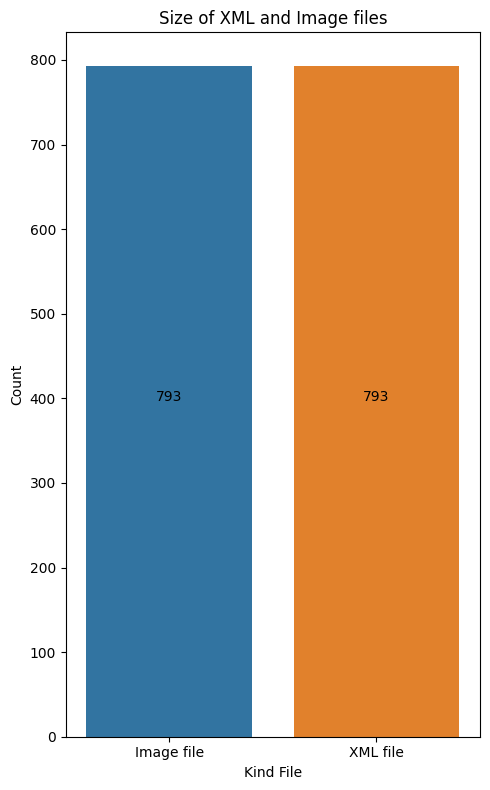

In [14]:
##Exploration data
#1. Exploration the number of image and label file


count_xml=len([file_path for file_path in os.listdir(os.getcwd()) if file_path.endswith(('xml','XML'))])
df_file=pd.DataFrame(data=[('Image file',len(data_image)),('XML file',count_xml)],columns=['Kind File','Count'])
plt.figure(figsize=(5,8))
ax=sns.barplot(data=df_file,x='Kind File',y='Count')
for idx,txt in enumerate(ax.get_xticks()):
    ax.text(txt,
                  df_file['Count'].to_numpy()[idx]/2,
                  str(df_file['Count'].to_numpy()[idx]),
                  ha='center')
plt.title('Size of XML and Image files')
plt.tight_layout()
plt.show()

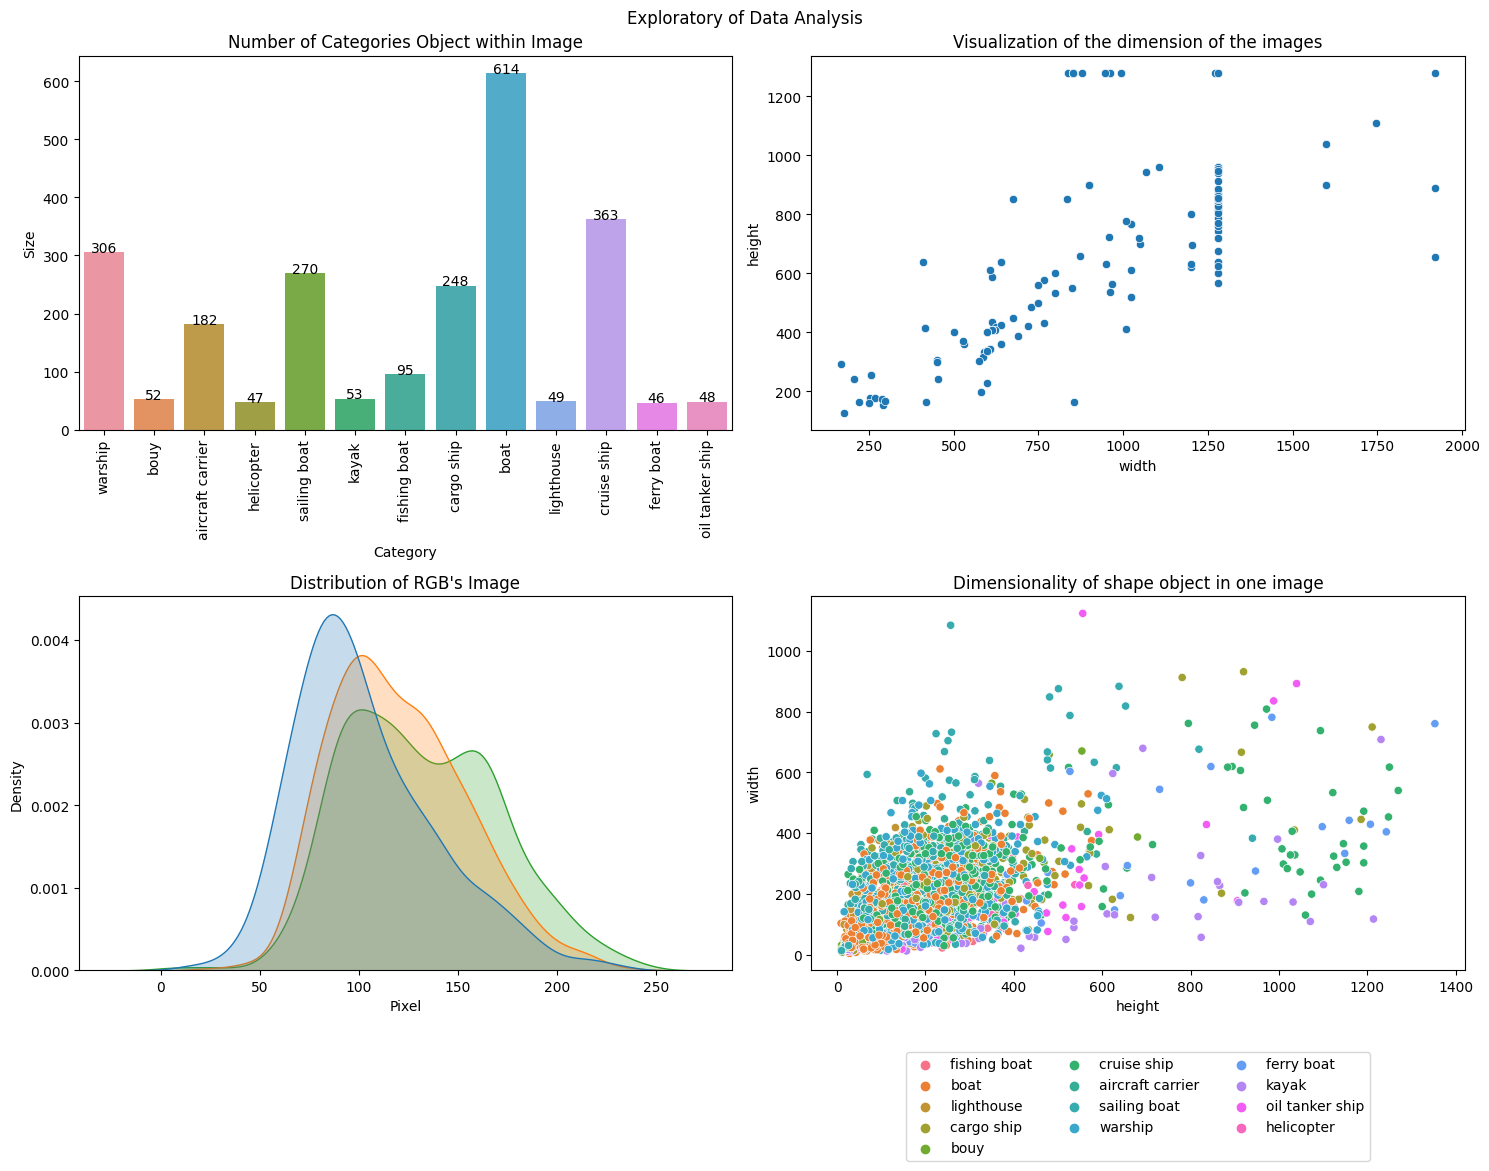

In [15]:
#2. Characteristics of images

fig,axe=plt.subplots(nrows=2,
                    ncols=2,
                    figsize=(15,12))

#Number of Image data
sns.barplot(data=df_category,x='category',y='size of category',ax=axe[0,0])
axe[0,0].set_xlabel('Category')
axe[0,0].set_ylabel('Size')
axe[0,0].tick_params(axis='x',labelrotation=90)
axe[0,0].set_title('Number of Categories Object within Image')
for idx,txt in enumerate(axe[0,0].get_xticks()):
    axe[0,0].text(txt,
                  df_category['size of category'].to_numpy()[idx]+0.25,
                  str(df_category['size of category'].to_numpy()[idx]),
                  ha='center')

#Scattering pixel
x=[]
y=[]
for img in data_image:
    x.append(img.shape[1])
    y.append(img.shape[0])
sns.scatterplot(x=x,
                y=y,
                ax=axe[0,1])
axe[0,1].set_xlabel('width')
axe[0,1].set_ylabel('height')
axe[0,1].set_title('Visualization of the dimension of the images')


#RGB Distribution
red_arr=[np.mean(data_image[idx][:,:,0]) for idx in range(len(data_image))]
green_arr=[np.mean(data_image[idx][:,:,1]) for idx in range(len(data_image))]
blue_arr=[np.mean(data_image[idx][:,:,2]) for idx in range(len(data_image))]


sns.kdeplot({'red':red_arr,
                  'green':green_arr,
                  'blue':blue_arr},
            color=['red','green','blue'],
            legend=False,
            fill=True,
            ax=axe[1,0])

axe[1,0].set_title("Distribution of RGB's Image")
plt.legend(['Red','Green','Blue'])
axe[1,0].set_xlabel('Pixel')

##Scattering plot based on category

sns.scatterplot(data=df_unit,
                x='shape_x',
                y='shape_y',
                hue='category')
axe[1,1].set_xlabel('height')
axe[1,1].set_ylabel('width')
axe[1,1].set_title('Dimensionality of shape object in one image')
axe[1,1].legend(loc='upper center',
                bbox_to_anchor=(0.5, -0.2),
                ncol=3)

plt.suptitle('Exploratory of Data Analysis')
plt.tight_layout()
plt.show()






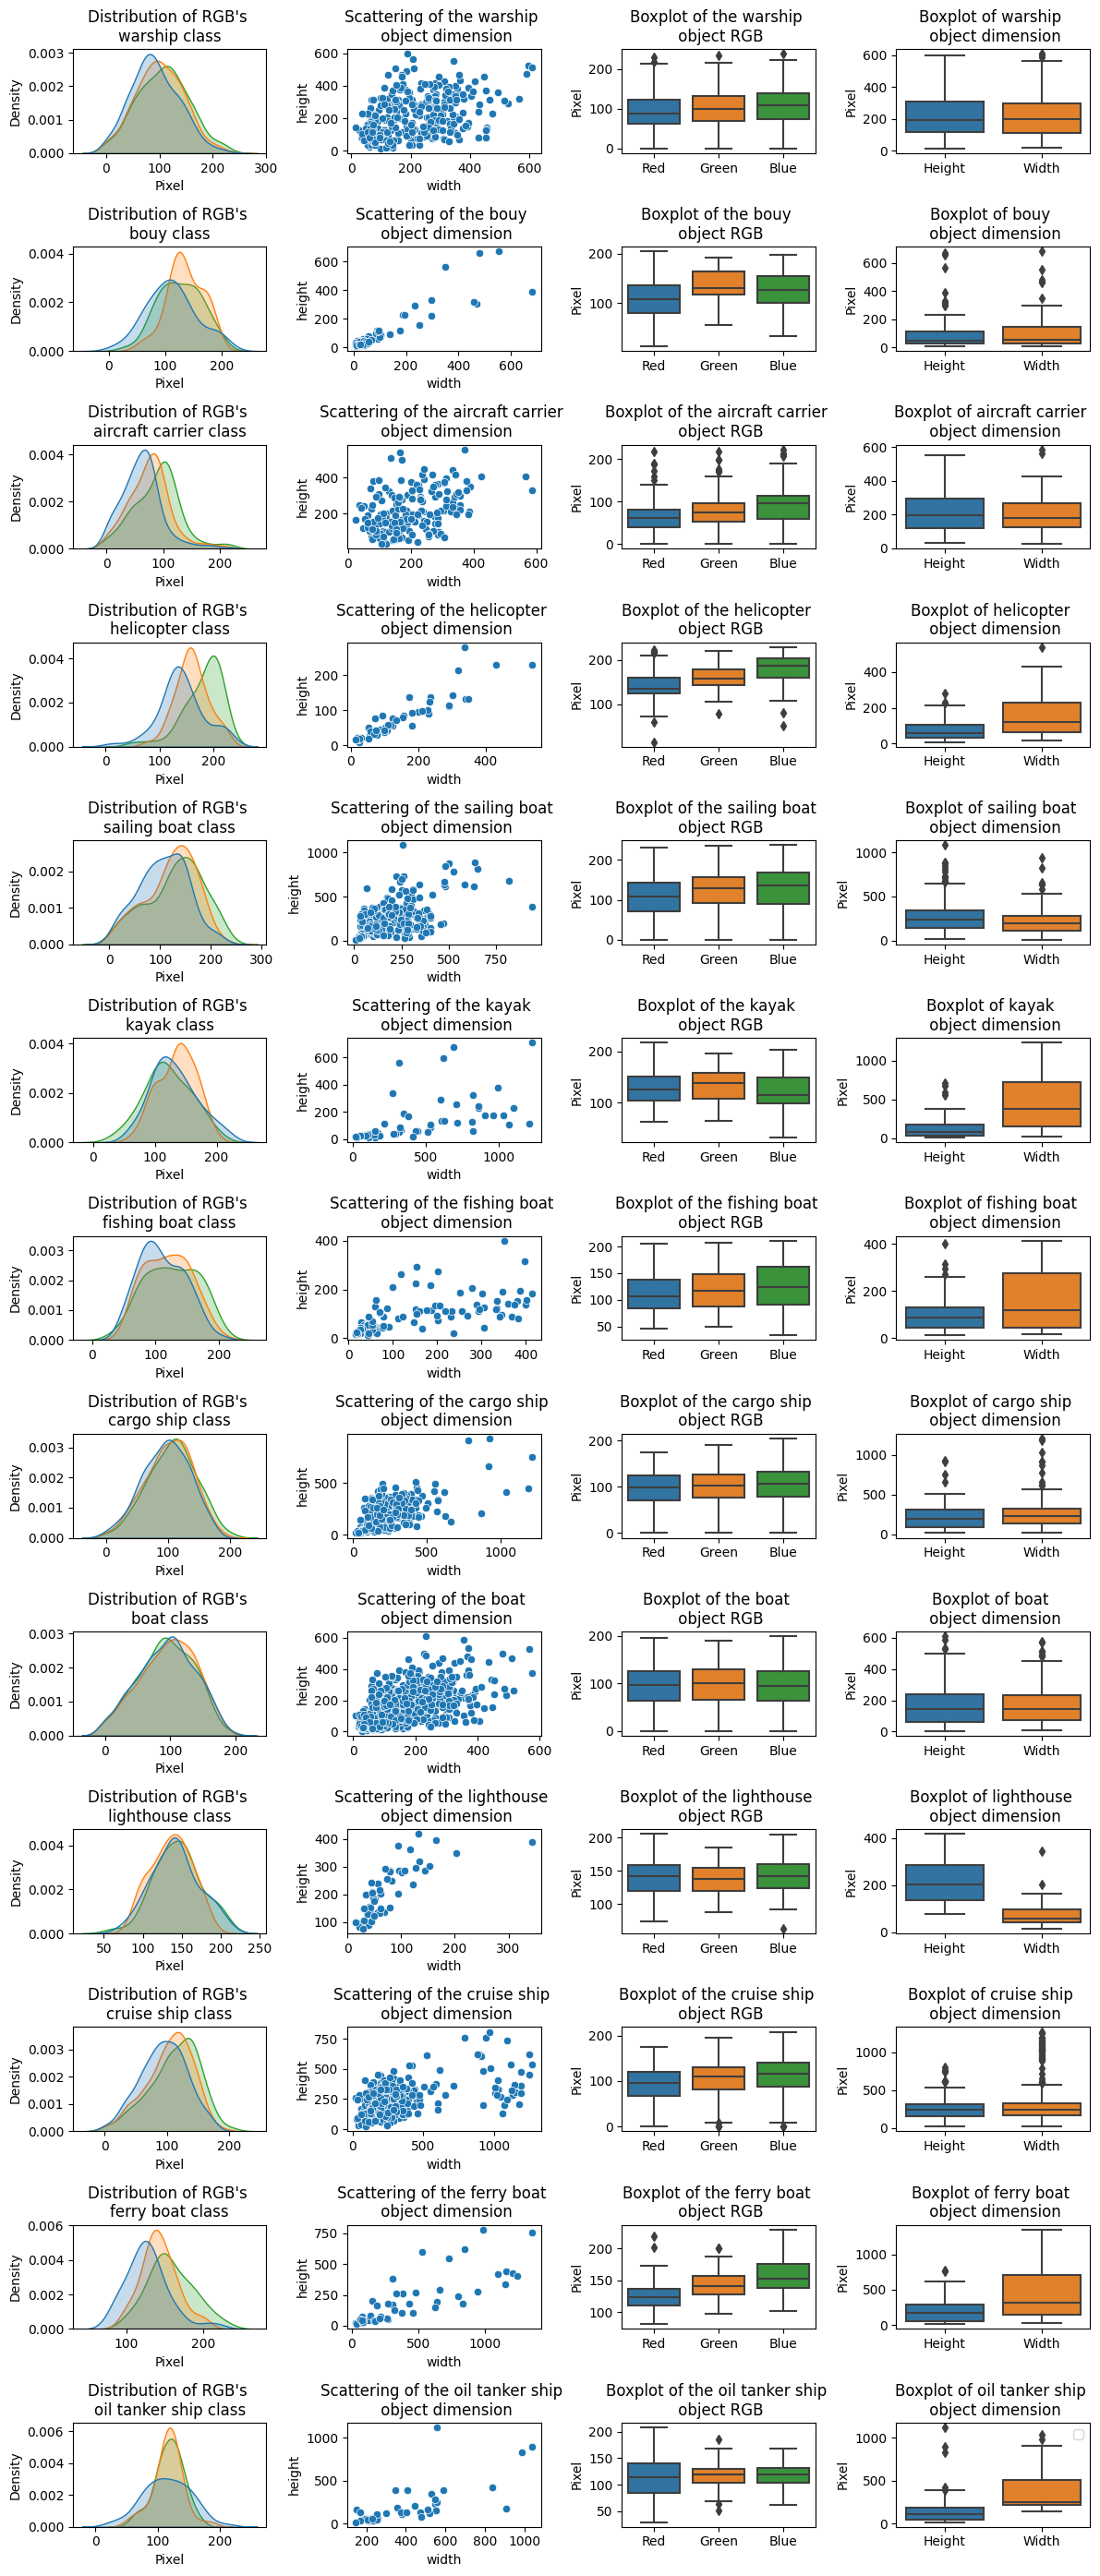

In [17]:
##Exploration of each category object data
fig,axe=plt.subplots(nrows=len(set(df_unit['category'].to_list())),
             ncols=4,
             figsize=(12,28))
for idx,cat in enumerate(set(df_unit['category'].to_list())):
    df_cat=df_unit[df_unit['category']==cat].copy()
    image_cat=cropping_obj(df=df_cat,
                           directory=os.getcwd())
    for jdx in range(4):
        if(jdx==0):
            #Distribution
            red_arr=[np.mean(image_cat[idx][:,:,0]) for idx in range(len(image_cat))]
            green_arr=[np.mean(image_cat[idx][:,:,1]) for idx in range(len(image_cat))]
            blue_arr=[np.mean(image_cat[idx][:,:,2]) for idx in range(len(image_cat))]

            sns.kdeplot({'red':red_arr,'green':green_arr,'blue':blue_arr},
                        color=['red','green','blue'],
                        legend=False,
                        fill=True,
                        ax=axe[idx,jdx])
            axe[idx,jdx].set_title(f"Distribution of RGB's \n{cat} class")
            plt.legend(['Red','Green','Blue'])
            axe[idx,jdx].set_xlabel('Pixel')

        elif (jdx==1):
            #Dimension
            x_shape=[x.shape[1] for x in image_cat]
            y_shape=[y.shape[0] for y in image_cat]
            sns.scatterplot(x=x_shape,
                y=y_shape,
                ax=axe[idx,jdx])
            axe[idx,jdx].set_xlabel('width')
            axe[idx,jdx].set_ylabel('height')
            axe[idx,jdx].set_title(f"Scattering of the {cat} \n object dimension")

        elif (jdx==2):
            #Boxplot RGB
            boxplot=sns.boxplot(data=[red_arr,green_arr,blue_arr],
                                orient='v',
                                ax=axe[idx,jdx])
            boxplot.set_xticklabels(['Red','Green','Blue'])
            axe[idx,jdx].set_title(f"Boxplot of the {cat} \n object RGB")
            axe[idx,jdx].set_ylabel('Pixel')

        else:
            #Boxplot Dimension
            boxplot=sns.boxplot(data=[y_shape, x_shape],
                                orient='v',
                                ax=axe[idx,jdx])
            boxplot.set_xticklabels(['Height','Width'])
            axe[idx,jdx].set_title(f"Boxplot of {cat} \n object dimension")
            axe[idx,jdx].set_ylabel('Pixel')
plt.tight_layout()
plt.show()



2. Preprocessing and Cleansing the Image Data

In [19]:
## Preprocessing

#1. Denoise image

pre_image=data_image.copy()
deblur_img=[]
for img in pre_image:
    deblur_img.append(cv2.fastNlMeansDenoisingColored(img,None,7,10,7,21))

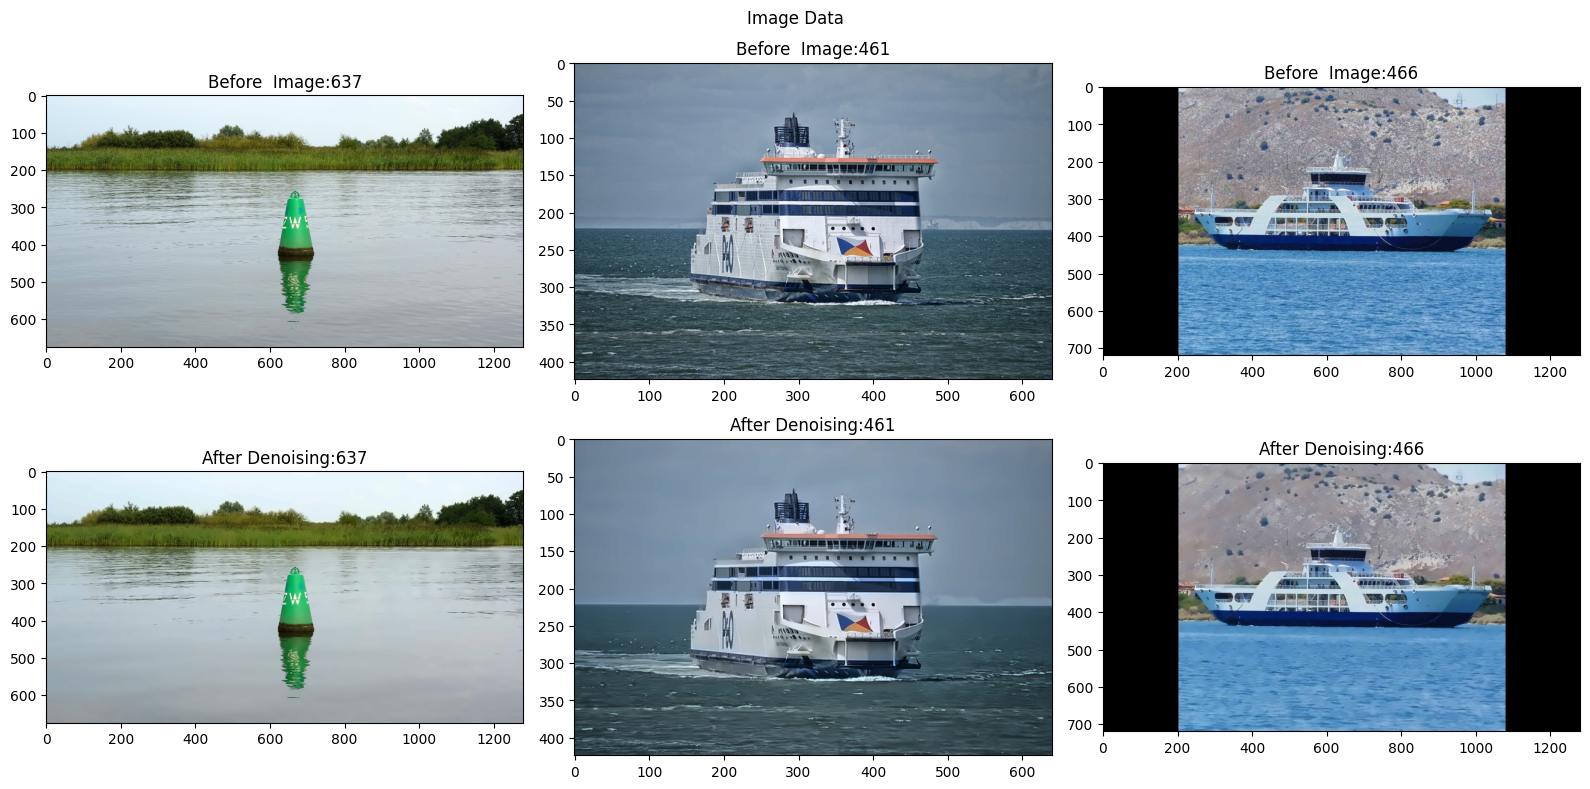

In [20]:
random_index=np.random.uniform(low=0,high=len(deblur_img), size=3)
random_index= [round(val) for val in random_index]
random_index=np.repeat([random_index],repeats=2,axis=0)


fig,axe=plt.subplots(nrows=2,ncols=3,figsize=(16,8))
plt.suptitle('Image Data')
for rows in range(random_index.shape[0]):
    for cols in range(random_index.shape[1]):
        if (rows==0):
            axe[rows,cols].imshow(pre_image[random_index[rows,cols]])
            val_rand=random_index[rows,cols]
            axe[rows,cols].set_title('Before  Image:%d' %val_rand)
            axe[rows,cols].grid(False)
        else:
            axe[rows,cols].imshow(deblur_img[random_index[rows,cols]])
            val_rand=random_index[rows,cols]
            axe[rows,cols].set_title('After Denoising:%d' %val_rand)
            axe[rows,cols].grid(False)
            
plt.tight_layout()
plt.show()

In [21]:

image_bound=[]
for path_img in os.listdir(os.getcwd()):
    if path_img.endswith(('jpg','png','JPG','PNG')):
        path_file=os.path.join(os.getcwd(),path_img)
        image=cv2.imread(path_file)
        conv=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_bound.append((path_img,conv))
        print(path_img,'is Successed for storing to array')
    else:
        continue
    clear_output(wait=True)
    time.sleep(0.001)



yacht-racing-sail-boat-sport-sea-642067 - Copy.jpg is Successed for storing to array


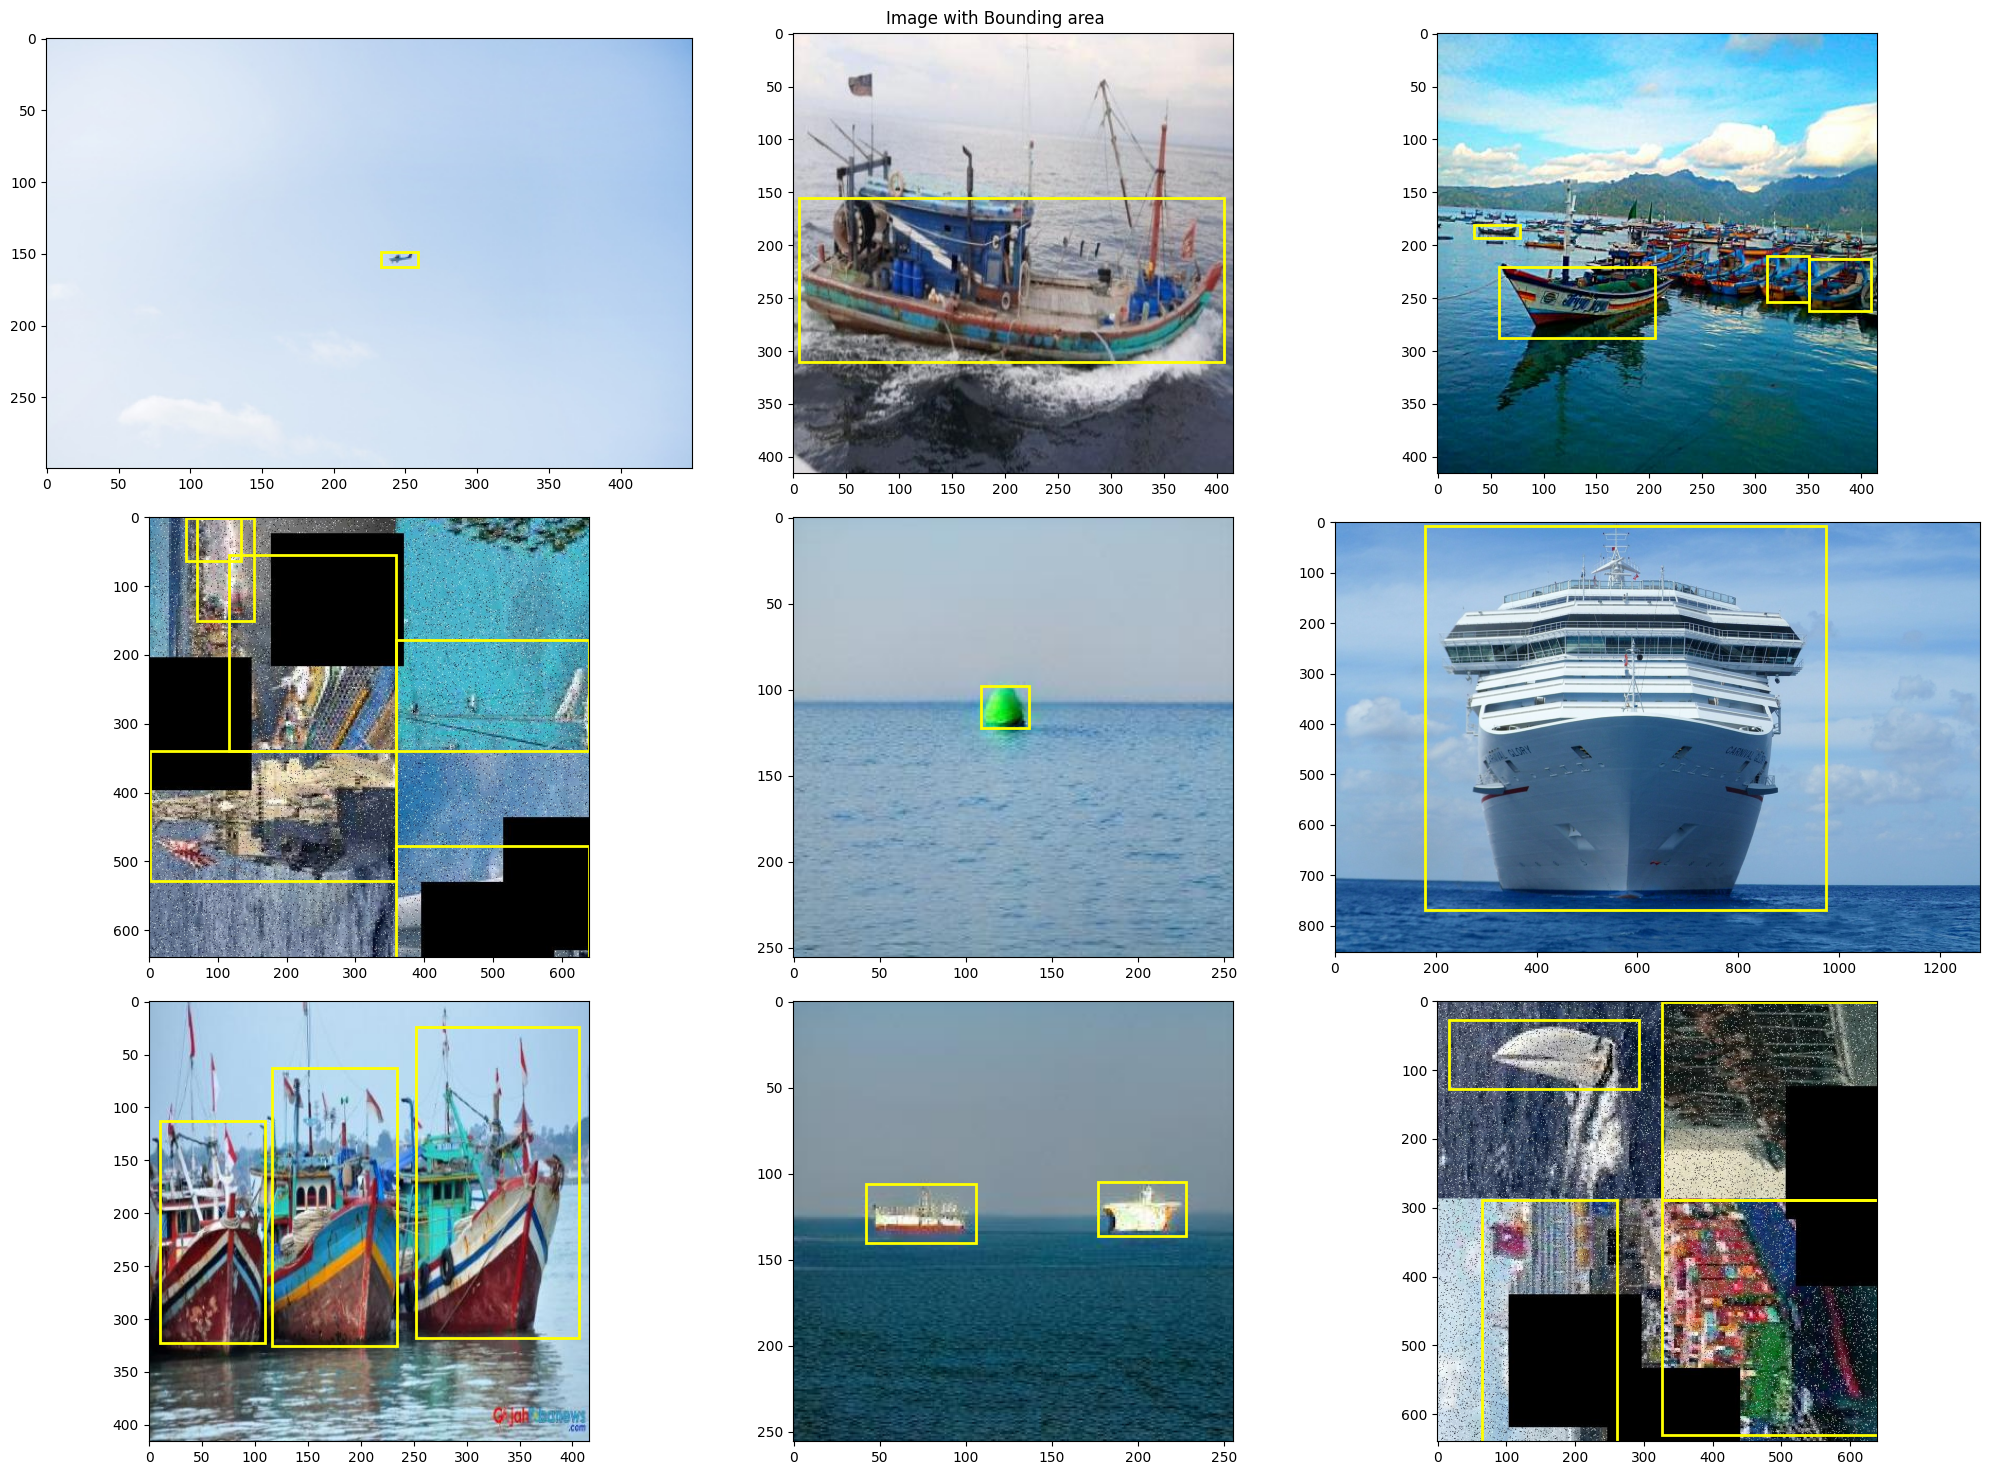

In [26]:
##Display the bndmax

random_index=np.random.uniform(low=0,high=len(deblur_img), size=9)
random_index= [round(val) for val in random_index]
random_index=np.reshape(random_index,(-1,3))


fig,axe=plt.subplots(nrows=3,ncols=3,figsize=(20,15))
image_bound_new=[]
for idx,img in enumerate(deblur_img):
    txt=image_bound[idx][0]
    image_bound_new.append((txt,img))
for i in range(random_index.shape[0]):
    for j in range(random_index.shape[1]):
        repo_bnd=df_unit[df_unit['filename']==image_bound[random_index[i,j]][0]]
        axe[i,j].imshow(image_bound[random_index[i,j]][1])
        for k in repo_bnd.index:
            axe[i,j].add_patch(Rectangle((repo_bnd.loc[k,'xmin'],repo_bnd.loc[k,'ymin']),
                                         width=repo_bnd.loc[k,'shape_x'],
                                         height=repo_bnd.loc[k,'shape_y'],
                                         edgecolor='yellow',
                                         fill=False,
                                         lw=2))

plt.suptitle(f'Image with Bounding area')
plt.tight_layout()
plt.show()


In [27]:
#2. Resizing image
image_resize=[]
df_resize=df_unit.copy()
resize_pixel=750
for img in image_bound:
    im_new, _, _, _, _,_, _ =resizing_image(image=img[1],resize=resize_pixel)
    image_resize.append(im_new)
    repo_bnd=df_unit[df_resize['filename']==img[0]]
    for k in repo_bnd.index:
        _,df_resize.loc[k,'xmin'],df_resize.loc[k,'ymin'],df_resize.loc[k,'xmax'],df_resize.loc[k,'ymax'],df_resize.loc[k,'shape_x'],df_resize.loc[k,'shape_y']=resizing_image(image=img[1],
                                                                                                                                                                               resize=resize_pixel,
                                                                                                                                                                             xmin=df_unit.loc[k,'xmin'],
                                                                                                                                                                             xmax=df_unit.loc[k,'xmax'],
                                                                                                                                                                             ymin=df_unit.loc[k,'ymin'],
                                                                                                                                                                             ymax=df_unit.loc[k,'ymax'])



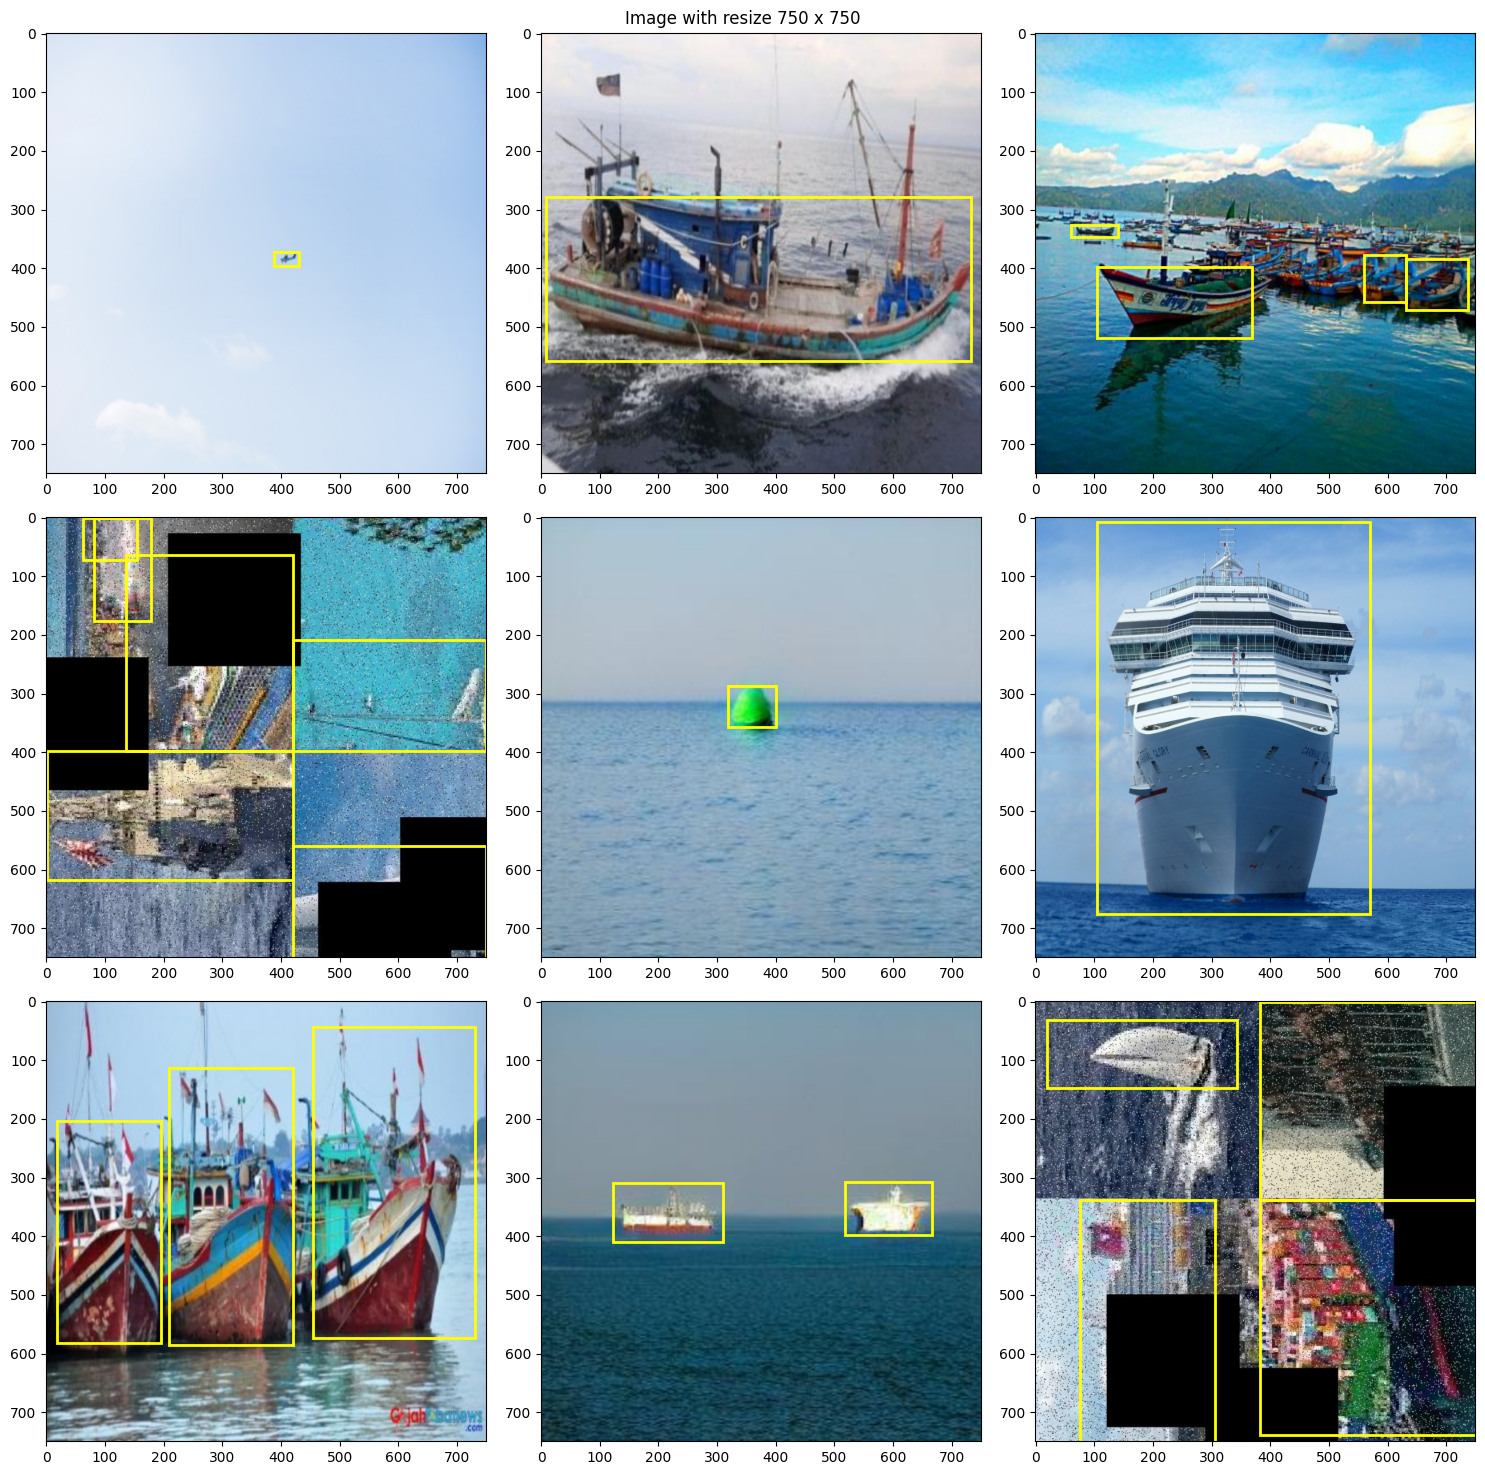

In [28]:
fig,axe=plt.subplots(nrows=3,ncols=3,figsize=(15,15))
image_bound_new=[]
for idx,img in enumerate(image_resize):
    txt=image_bound[idx][0]
    image_bound_new.append((txt,img))
for i in range(random_index.shape[0]):
    for j in range(random_index.shape[1]):
        repo_bnd=df_resize[df_resize['filename']==image_bound_new[random_index[i,j]][0]]
        axe[i,j].imshow(image_bound_new[random_index[i,j]][1])
        for k in repo_bnd.index:
            axe[i,j].add_patch(Rectangle((repo_bnd.loc[k,'xmin'],repo_bnd.loc[k,'ymin']),
                                         width=repo_bnd.loc[k,'shape_x'],
                                         height=repo_bnd.loc[k,'shape_y'],
                                         edgecolor='yellow',
                                         fill=False,
                                         lw=2))

plt.suptitle(f'Image with resize {resize_pixel} x {resize_pixel}')
plt.tight_layout()
plt.show()


3. Modeling and Augmenting Data

filename      category  xmin  \
0     011155520170325-010755-8912-kapal-ne_jpg.rf.25...  fishing boat   151   
1     08112012371-kecil_jpg.rf.c040f397b91232463ea73...          boat   432   
2     08112012371-kecil_jpg.rf.c040f397b91232463ea73...  fishing boat    16   
3     0afa92fc0f8a9cf051bf2961b06ac56b_XL_jpg.rf.27d...  fishing boat   454   
4     0afa92fc0f8a9cf051bf2961b06ac56b_XL_jpg.rf.27d...  fishing boat   209   
...                                                 ...           ...   ...   
2368  yacht-9_jpg.rf.f0929bbdbb3e69921d51a9f62f85a2c...   cruise ship    53   
2369  yacht-racing-sail-boat-sport-sea-642067 - Copy...  sailing boat   270   
2370  yacht-racing-sail-boat-sport-sea-642067 - Copy...          boat   293   
2371  yacht-racing-sail-boat-sport-sea-642067 - Copy...          boat   599   
2372  yacht-racing-sail-boat-sport-sea-642067 - Copy...  sailing boat   630   

      ymin  xmax  ymax  shape_x  shape_y  
0      353   515   486      364      133  
1      311   692   385      260       74  
2      439   739   685      723      246  
3       43   731   573      277      530  
4      113   421   585      212      472  
...    ...   ...   ...      ...      ...  
2368   139   725   554      672      415  
2369   215   378   555      108      340  
2370   343   314   364       21       21  
2371   430   618   450       19       20  
2372   333   645   360       15       27  

[2373 rows x 8 columns]

In [24]:
##Saving all the preprocessing

for obj in image_bound_new:
    filename,img=obj
    path_file=os.path.join("D:/Workspace for Coding/Project Detection of Marine Object/Dataset/Data Ship/Denoise and Resize",filename)
    cv2.imwrite(filename=path_file,img=img)

In [6]:
##FRCNN-RESNET50


model=FRCNN_RESNET50_Model(10)
model.roi_heads.box_predictor.cls_score.in_features

c:\Users\microsoft\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\microsoft\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


False

In [30]:
##Detecto Training
dataset_label=Detecto_File_CSV(label_path="D:/Workspace for Coding/Project Detection of Marine Object/Dataset/Data Ship/Annotation",
                         save_to="D:/Workspace for Coding/Project Detection of Marine Object/Dataset/Data Ship/data_train.csv")
category=set(dataset_label['class'])
for idx,name in enumerate(dataset_label.filename):
    if dataset_label.loc[idx,'filename']==df_resize.loc[idx,'filename']:
        dataset_label.loc[idx,'xmin']=df_resize.loc[idx,'xmin']
        dataset_label.loc[idx,'ymin']=df_resize.loc[idx,'ymin']
        dataset_label.loc[idx,'xmax']=df_resize.loc[idx,'xmax']
        dataset_label.loc[idx,'ymax']=df_resize.loc[idx,'ymax']
        dataset_label.loc[idx,'class']=df_resize.loc[idx,'category']
dataset_label.head()

filename  width  height  \
0  011155520170325-010755-8912-kapal-ne_jpg.rf.25...    416     416   
1  08112012371-kecil_jpg.rf.c040f397b91232463ea73...    416     416   
2  08112012371-kecil_jpg.rf.c040f397b91232463ea73...    416     416   
3  0afa92fc0f8a9cf051bf2961b06ac56b_XL_jpg.rf.27d...    416     416   
4  0afa92fc0f8a9cf051bf2961b06ac56b_XL_jpg.rf.27d...    416     416   

          class  xmin  ymin  xmax  ymax  image_id  
0  fishing boat   151   353   515   486         0  
1          boat   432   311   692   385         1  
2  fishing boat    16   439   739   685         1  
3  fishing boat   454    43   731   573         2  
4  fishing boat   209   113   421   585         2

In [31]:
dataset_label.to_csv('D:/Workspace for Coding/Project Detection of Marine Object/Dataset/Data Ship/data_train1.csv',index=False)

In [32]:
history,classifier=Detecto_train(dataset_csv="D:/Workspace for Coding/Project Detection of Marine Object/Dataset/Data Ship/data_train.csv",
              image_path="D:/Workspace for Coding/Project Detection of Marine Object/Dataset/Data Ship/Denoise and Resize",
              categories=list(category))

Here your dataloader <detecto.core.DataLoader object at 0x0000024E2DC9CBB0>


c:\Users\microsoft\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\microsoft\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 of 25
Begin iterating over training dataset


100%|██████████| 793/793 [04:50<00:00,  2.73it/s]


Epoch 2 of 25
Begin iterating over training dataset


100%|██████████| 793/793 [04:44<00:00,  2.79it/s]


Epoch 3 of 25
Begin iterating over training dataset


100%|██████████| 793/793 [04:44<00:00,  2.79it/s]


Epoch 4 of 25
Begin iterating over training dataset


100%|██████████| 793/793 [04:53<00:00,  2.70it/s]


Epoch 5 of 25
Begin iterating over training dataset


100%|██████████| 793/793 [04:47<00:00,  2.76it/s]


Epoch 6 of 25
Begin iterating over training dataset


100%|██████████| 793/793 [04:48<00:00,  2.75it/s]


Epoch 7 of 25
Begin iterating over training dataset


100%|██████████| 793/793 [04:48<00:00,  2.75it/s]


Epoch 8 of 25
Begin iterating over training dataset


100%|██████████| 793/793 [04:54<00:00,  2.69it/s]


Epoch 9 of 25
Begin iterating over training dataset


100%|██████████| 793/793 [04:55<00:00,  2.68it/s]


Epoch 10 of 25
Begin iterating over training dataset


100%|██████████| 793/793 [04:50<00:00,  2.73it/s]


Epoch 11 of 25
Begin iterating over training dataset


100%|██████████| 793/793 [04:46<00:00,  2.77it/s]


Epoch 12 of 25
Begin iterating over training dataset


100%|██████████| 793/793 [04:47<00:00,  2.76it/s]


Epoch 13 of 25
Begin iterating over training dataset


100%|██████████| 793/793 [04:50<00:00,  2.73it/s]


Epoch 14 of 25
Begin iterating over training dataset


100%|██████████| 793/793 [04:49<00:00,  2.74it/s]


Epoch 15 of 25
Begin iterating over training dataset


100%|██████████| 793/793 [05:04<00:00,  2.60it/s]


Epoch 16 of 25
Begin iterating over training dataset


100%|██████████| 793/793 [05:15<00:00,  2.51it/s]


Epoch 17 of 25
Begin iterating over training dataset


100%|██████████| 793/793 [05:15<00:00,  2.52it/s]


Epoch 18 of 25
Begin iterating over training dataset


100%|██████████| 793/793 [04:54<00:00,  2.70it/s]


Epoch 19 of 25
Begin iterating over training dataset


100%|██████████| 793/793 [04:56<00:00,  2.68it/s]


Epoch 20 of 25
Begin iterating over training dataset


100%|██████████| 793/793 [04:55<00:00,  2.69it/s]


Epoch 21 of 25
Begin iterating over training dataset


100%|██████████| 793/793 [05:27<00:00,  2.42it/s]


Epoch 22 of 25
Begin iterating over training dataset


100%|██████████| 793/793 [05:29<00:00,  2.41it/s]


Epoch 23 of 25
Begin iterating over training dataset


100%|██████████| 793/793 [05:23<00:00,  2.45it/s]


Epoch 24 of 25
Begin iterating over training dataset


100%|██████████| 793/793 [05:25<00:00,  2.43it/s]


Epoch 25 of 25
Begin iterating over training dataset


100%|██████████| 793/793 [05:13<00:00,  2.53it/s]


In [33]:
classifier.save('D:/Workspace for Coding/Project Detection of Marine Object/Dataset/Data Ship/model_detection_ship.pth')

In [37]:
os.getcwd()

'D:\\Workspace for Coding\\Project Detection of Marine Object\\Dataset\\Pict'

In [38]:
from detecto import visualize
visualize.detect_video(classifier,
                       "D:\Workspace for Coding\Project Detection of Marine Object\Dataset\Data Ship\x2mate.com-Many ships in the Sea-(480p).mp4",
                       "D:\Workspace for Coding\Project Detection of Marine Object\Dataset\Data Ship\output.avi",fps=30)
visualize.detect_live(classifier)

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 76-78: truncated \xXX escape (410055376.py, line 3)